---
## DATASET B

In [ ]:
install.packages(c("forecast", "tsibble", "psych", "tseries", "rugarch","tseries","FinTS","zoo"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘BH’, ‘TTR’, ‘truncnorm’, ‘future.apply’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’, ‘anytime’, ‘mnormt’, ‘GPArotation’, ‘quadprog’, ‘quantmod’, ‘Rsolnp’, ‘ks’, ‘numDeriv’, ‘spd’, ‘xts’, ‘chron’, ‘SkewHyperbolic’, ‘nloptr’




In [ ]:
library(tidyverse)
library(forecast)
library(tsibble)
library(psych)
library(tseries)
library(rugarch)
library(TTR)
library(tseries)
library(FinTS)
library(zoo)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: ‘tsibble’


The following object is masked from ‘package:lubridate’:

    interval


The following objects are masked from ‘package:base’:

    intersect, setdiff, union



Attaching package: ‘psych’


The following objects are masked from ‘package:gg

In [ ]:
df <- read.csv("dataset_b.csv")
sales_ts <- ts(df$sales,
               start = c(df$yr_nbr[1], df$wk_in_yr_nbr[1]),
               frequency = 52)

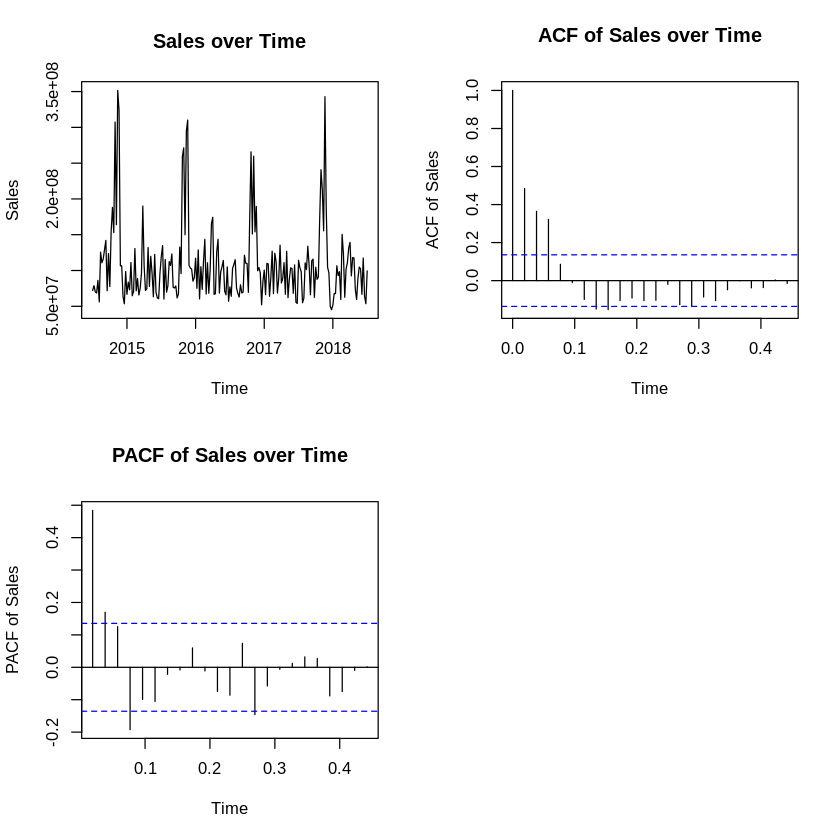

In [ ]:
par(mfrow = c(2, 2))
plot(sales_ts,
     main = "Sales over Time",
     ylab = "Sales",
     xlab = "Time")
acf(sales_ts,
     main = "ACF of Sales over Time",
     ylab = "ACF of Sales",
     xlab = "Time")
pacf(sales_ts,
      main = "PACF of Sales over Time",
      ylab = "PACF of Sales",
      xlab = "Time")

* The data shows that there are no consistent trend or seasonality present within the data for sales, however there seems to have peaks that are introduced by another variable.
* ACF plot shows that the sales corrolate significantly onto sales from previous sales where it is sustained up to the 4th lag.
* PACF shows that after removing the cascading influence from other lags it shows that lags 1 and 2 are the only significant, showing that only lag of 2 shows true significance.

Based on the plots we can determine that the data supports a low level AR and MA.


In [ ]:
adf.test(sales_ts)

Warning message in adf.test(sales_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  sales_ts
Dickey-Fuller = -6.0328, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


Based on the Augmented Dickey-Fuller Test we can determine whether or not the sales data is stationary, wherein the p-value shows itself to have a value less than 0.05 indicating that the sales data is stationary, thus, indicating that ARIMA or ARIMAX are perfect model candidates for the data.

In [ ]:
arima_sales  <- auto.arima(sales_ts)
summary(arima_sales)

Series: sales_ts 
ARIMA(0,0,1)(0,1,1)[52] 

Coefficients:
          ma1     sma1
      -0.1294  -0.5870
s.e.   0.0753   0.1556

sigma^2 = 1.517e+15:  log likelihood = -2976.39
AIC=5958.77   AICc=5958.93   BIC=5967.94

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set -2166788 33538357 21825810 -6.682839 22.06546 0.6656732
                    ACF1
Training set -0.01356842


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1)(0,1,1)[52]
Q* = 35.158, df = 40, p-value = 0.6877

Model df: 2.   Total lags used: 42



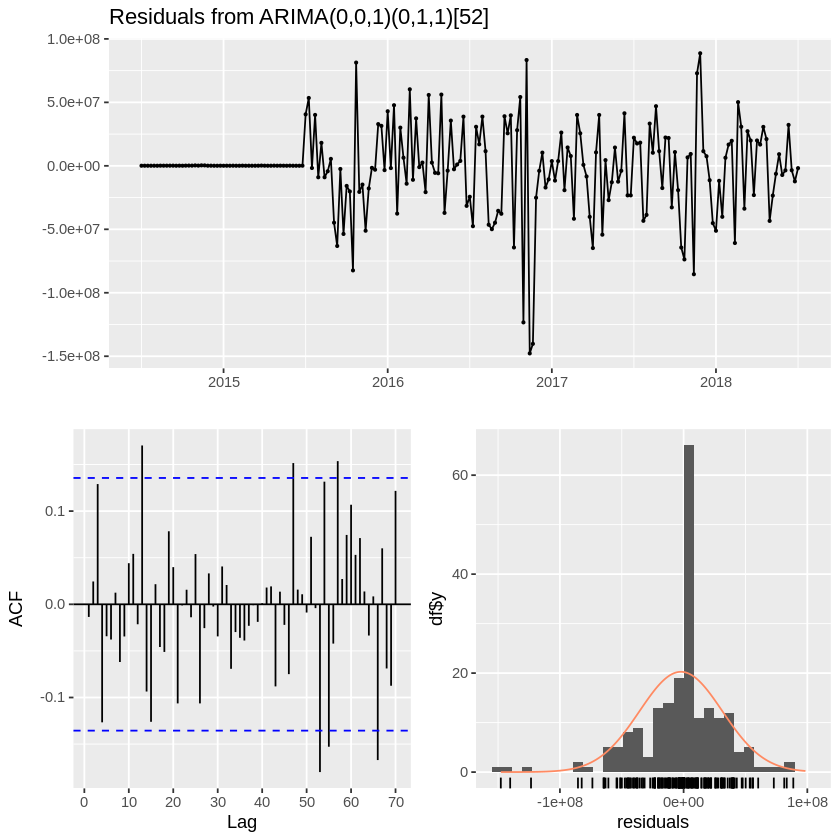

In [ ]:
checkresiduals(arima_sales)

The model plots shows that the residuals produces are uncorrolated and closely resembles a normal distribution.

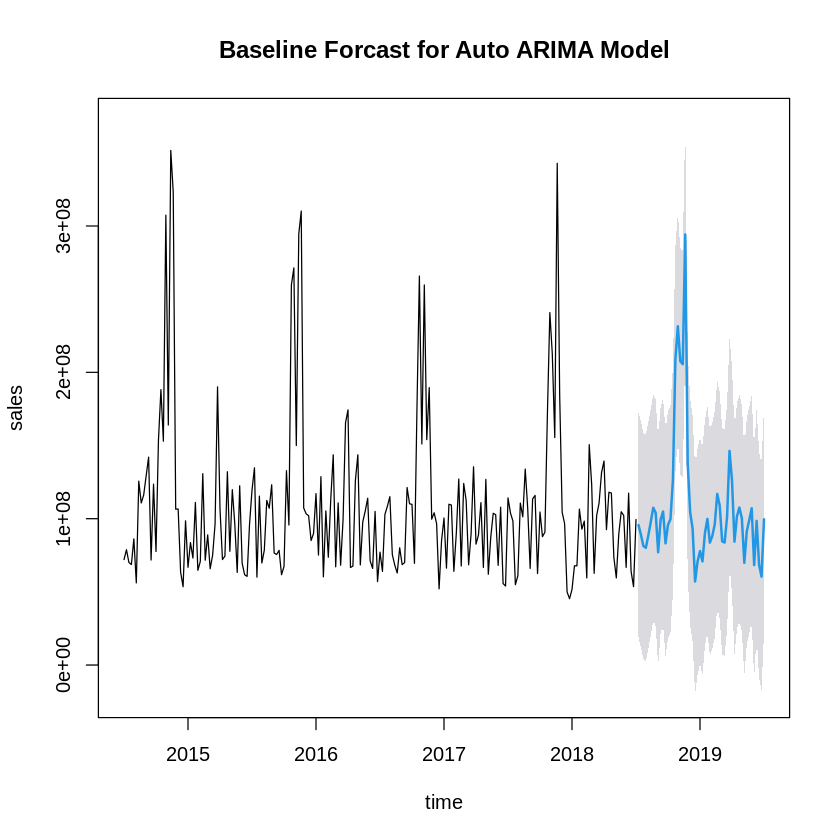

In [ ]:
arima_forcast<-forecast(arima_sales, h = 52, level = 95)
plot(arima_forcast,main="Baseline Forcast for Auto ARIMA Model",xlab = "time",ylab = "sales")

# **Prewhitening**

In [ ]:
ad_ts <- ts(df$mdsp_on, start = c(df$yr_nbr[1], df$wk_in_yr_nbr[1]), frequency = 52)
arima_ad<-auto.arima(ad_ts)
summary(arima_ad)

Series: ad_ts 
ARIMA(0,1,2)(1,1,0)[52] 

Coefficients:
          ma1      ma2     sar1
      -0.8851  -0.0729  -0.4707
s.e.   0.0750   0.0742   0.0838

sigma^2 = 1.021e+10:  log likelihood = -2025.27
AIC=4058.55   AICc=4058.81   BIC=4070.75

Training set error measures:
                   ME     RMSE     MAE       MPE     MAPE      MASE
Training set 7732.038 86459.46 59511.3 -7.189601 29.32381 0.6575249
                     ACF1
Training set -0.008183836

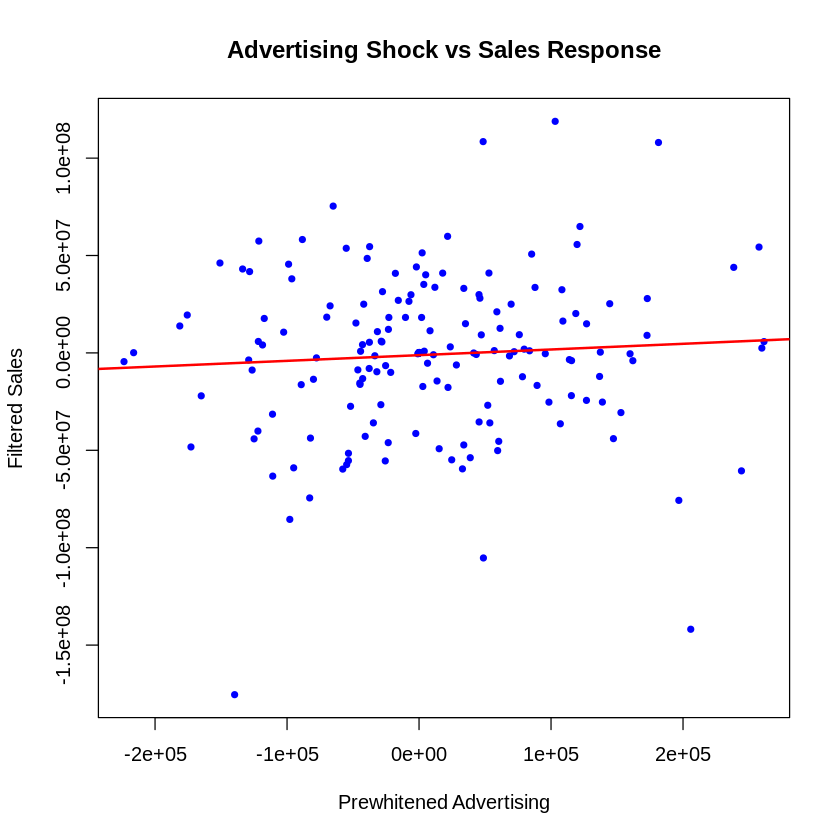

In [ ]:
ad_white <- residuals(arima_ad)
sales_white <- residuals(Arima(sales_ts,
                               order = c(0,1,2),
                               seasonal = list(order=c(1,1,0), period=52),
                               fixed = arima_ad$coef))

white_data <- data.frame(
  ad = ad_white,
  sales = sales_white,
  time = time(ad_white)
)

plot(white_data$ad, white_data$sales,
     xlab = "Prewhitened Advertising",
     ylab = "Filtered Sales",
     main = "Advertising Shock vs Sales Response",
     pch = 20, col = "blue")

abline(lm(sales ~ ad, data = white_data), col = "red", lwd = 2)

Based on the pre-whitened advertising and pre-whitened sales, there appears to be a positive relationship; however, as the figure shows, it is weak. This suggests that the peaks in sales cannot be well explained by advertising alone.

# **Cross-correlation Identification**

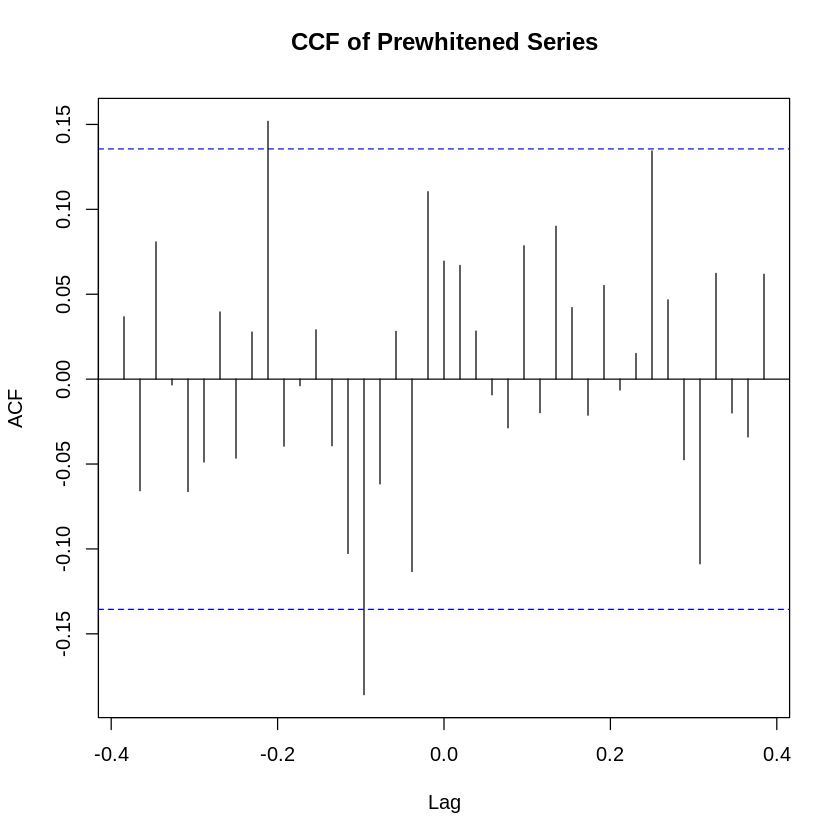

In [ ]:
ccf(ad_white, sales_white, main="CCF of Prewhitened Series")

The CCF of the pre-whitened series shows a few peaks at different lags, but only two of them is statistically significant. The remaining peaks are small and not significant, and the correlation generally decreases as the lag increases. This suggests that advertising has a limited effect on sales, with only two lag showing a meaningful impact.

# **ARIMAX/Transfer Function model**

In [ ]:
ads_lag10 <- stats::lag(ad_ts, -10)
ads_lag16 <- stats::lag(ad_ts, -16)

combined_ts <- ts.intersect(sales = sales_ts,
                           ad_lag10 = ads_lag10,
                           ad_lag16 = ads_lag16)

sales_aligned <- combined_ts[, "sales"]
X_aligned <- combined_ts[, c("ad_lag10", "ad_lag16")]

sales_scaled <- scale(sales_aligned)

ad_lag10_scaled <- scale(X_aligned[,1])
ad_lag16_scaled <- scale(X_aligned[,2])

arimax_tf <- arima(sales_scaled, order = c(0, 0, 1),
                       xreg = cbind(ad_lag10_scaled, ad_lag16_scaled))
summary(arimax_tf)

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = sales_scaled, order = c(0, 0, 1), xreg = cbind(ad_lag10_scaled, ad_lag16_scaled))

Coefficients:
         ma1  intercept  ad_lag10_scaled  ad_lag16_scaled
      0.4096    -0.0014          -0.0320          -0.0855
s.e.  0.0647     0.0908           0.0751           0.0756

sigma^2 estimated as 0.8039:  log likelihood = -252.88,  aic = 513.77

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

The ARIMAX model results indicate that the MA(1) term is significant, suggesting that sales are largely influenced by short-term autocorrelation in past values. In contrast, the advertising lags at 10 and 16 weeks have small and statistically insignificant coefficients, indicating that advertising has little impact on sales within this model. Overall, the variation in sales is primarily driven by past sales rather than the lagged effects of advertising.


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 51.866, df = 38, p-value = 0.06622

Model df: 1.   Total lags used: 39



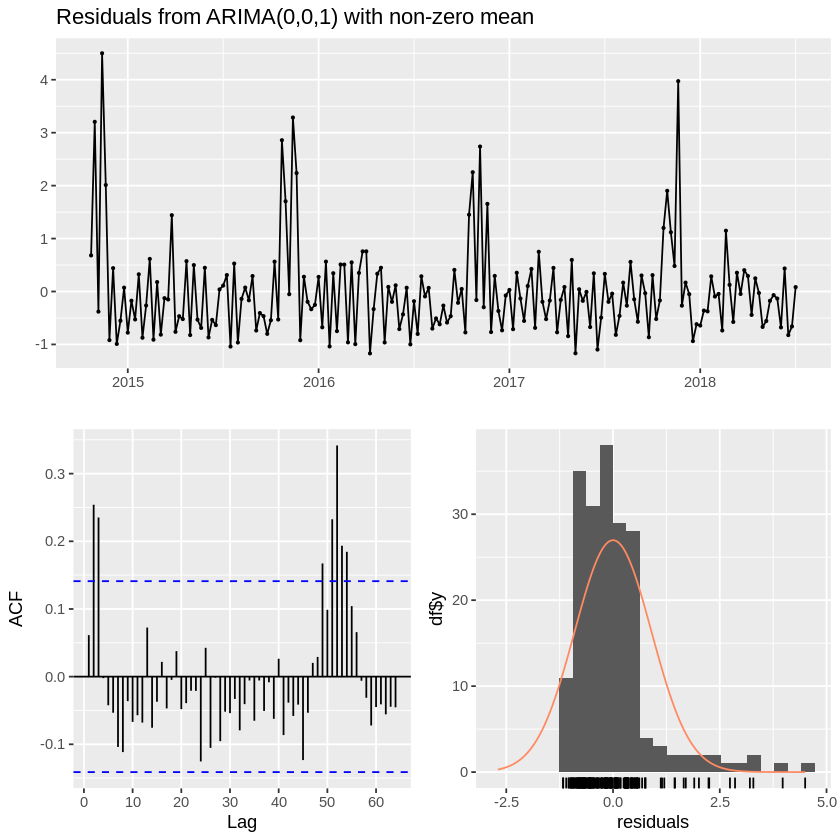

In [ ]:
checkresiduals(arimax_tf)

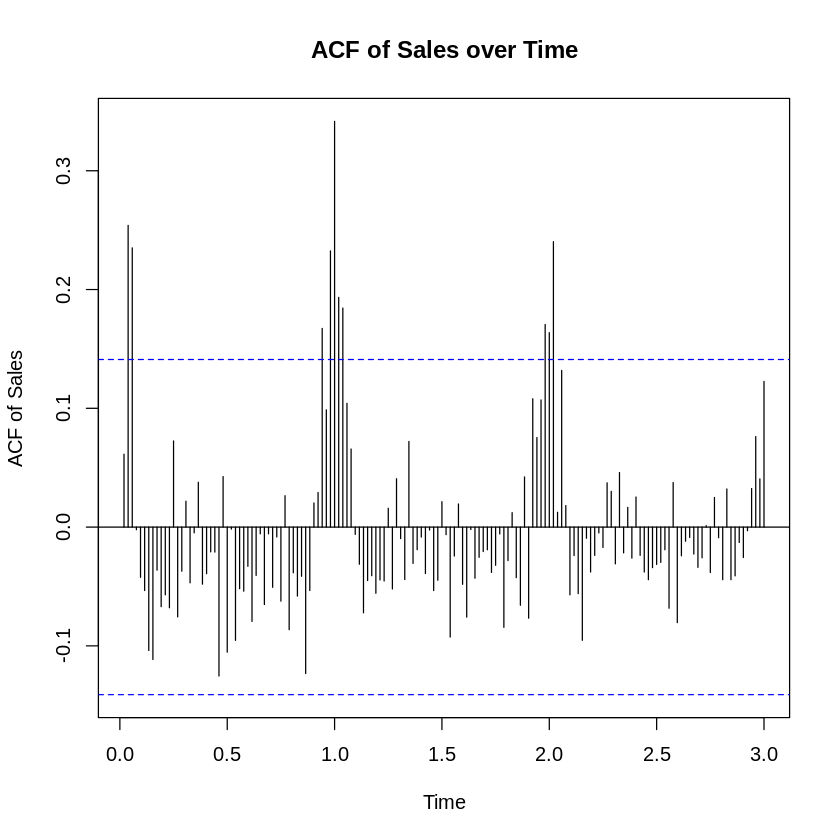

In [ ]:
acf(residuals(arimax_tf),
     main = "ACF of Sales over Time",
     ylab = "ACF of Sales",
     xlab = "Time",
     lag.max = 156
     )

The Ljung-Box test on the residuals of the ARIMA(0,0,1) model suggests that, overall, there is no strong autocorrelation remaining (Q* = 51.87, p = 0.066), indicating that the model captures much of the time series structure. With the analysis of residuals we can observe that given a large enough lag it shows a persitent residual correlation as the years progress, indicating a presence of seasonality that the ARIMAX model failed to capture.

In [ ]:
ads_lag10 <- stats::lag(ad_ts, -10)
ads_lag16 <- stats::lag(ad_ts, -16)

combined_ts <- ts.intersect(sales = sales_ts,
                           ad_lag10 = ads_lag10,
                           ad_lag16 = ads_lag16)

sales_aligned <- combined_ts[, "sales"]
X_aligned <- combined_ts[, c("ad_lag10", "ad_lag16")]

sales_scaled <- scale(sales_aligned)

ad_lag10_scaled <- scale(X_aligned[,1])
ad_lag16_scaled <- scale(X_aligned[,2])

arimax_tf <- arima(sales_scaled, order = c(0, 0, 1),
                       xreg = cbind(ad_lag10_scaled, ad_lag16_scaled),
                       seasonal = list(order = c(0, 1, 1), period = 52)
                       )
summary(arimax_tf)

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = sales_scaled, order = c(0, 0, 1), seasonal = list(order = c(0, 1, 
    1), period = 52), xreg = cbind(ad_lag10_scaled, ad_lag16_scaled))

Coefficients:
          ma1     sma1  ad_lag10_scaled  ad_lag16_scaled
      -0.1505  -0.5736          -0.0289          -0.0686
s.e.   0.0837   0.1649           0.0680           0.0698

sigma^2 estimated as 0.483:  log likelihood = -158.66,  aic = 325.32

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1)(0,1,1)[52]
Q* = 39.187, df = 37, p-value = 0.372

Model df: 2.   Total lags used: 39



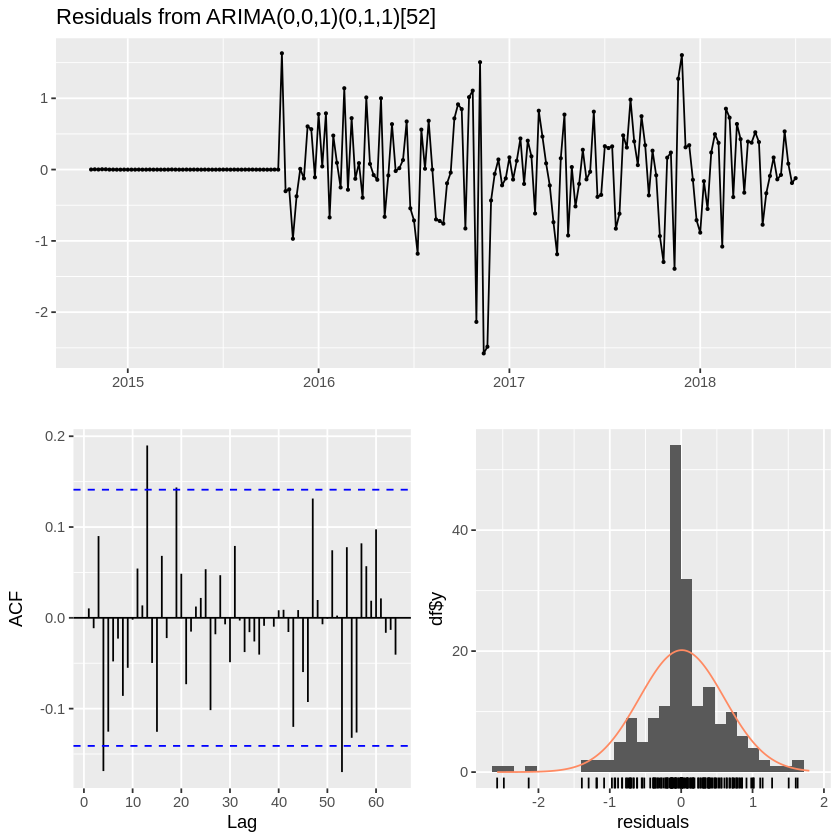

In [ ]:
checkresiduals(arimax_tf)

In [ ]:
ArchTest(residuals(arimax_tf))


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  residuals(arimax_tf)
Chi-squared = 54.936, df = 12, p-value = 1.859e-07


Based on the ARCH LM-test shows that the variance within the data is minor and not statistically significant, meaning there is a constant varying variance.

# **Forecast**

Warning message in z[[1L]] + xm:
“longer object length is not a multiple of shorter object length”
Warning message:
“Removed 52 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 209 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 209 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”


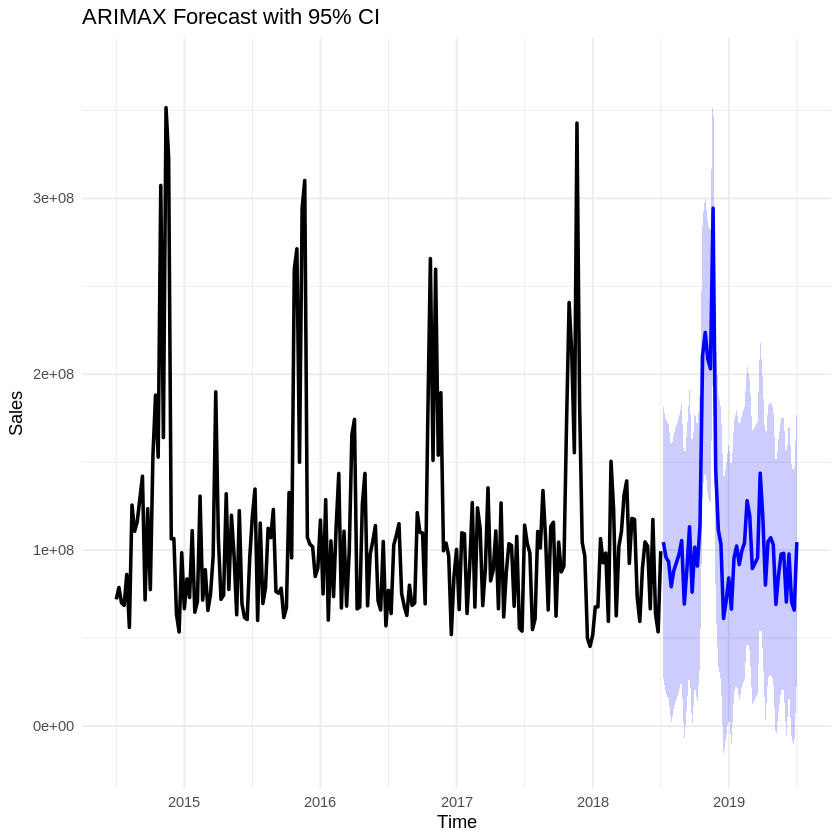

In [ ]:
h=52
center <- c(attr(ad_lag10_scaled, "scaled:center"),
            attr(ad_lag16_scaled, "scaled:center"))

scale_ <- c(attr(ad_lag10_scaled, "scaled:scale"),
            attr(ad_lag16_scaled, "scaled:scale"))

future_X_scaled <- scale(future_X, center = center, scale = scale_)

arimax_forecast <- predict(arimax_tf, n.ahead = h, newxreg = future_X_scaled)

forecast_scaled <- arimax_forecast$pred

forecast_original <- forecast_scaled * attr(sales_scaled, "scaled:scale") + attr(sales_scaled, "scaled:center")

upper <- forecast_original + 1.96 * arimax_forecast$se * attr(sales_scaled, "scaled:scale")
lower <- forecast_original - 1.96 * arimax_forecast$se * attr(sales_scaled, "scaled:scale")

time_all <- as.numeric(time(sales_ts))
time_forecast <- seq(from = tail(time_all, 1) + 1/52,
                     by = 1/52,
                     length.out = h)

plot_df <- data.frame(
  time = c(time_all, time_forecast),
  sales = c(as.numeric(sales_ts), rep(NA, h)),
  forecast = c(rep(NA, length(sales_ts)), forecast_original),
  lower = c(rep(NA, length(sales_ts)), lower),
  upper = c(rep(NA, length(sales_ts)), upper)
)

ggplot(plot_df) +
  geom_line(aes(x = time, y = sales), color = "black", size = 1) +
  geom_line(aes(x = time, y = forecast), color = "blue", size = 1) +
  geom_ribbon(aes(x = time, ymin = lower, ymax = upper), fill = "blue", alpha = 0.2) +
  labs(x = "Time", y = "Sales", title = "ARIMAX Forecast with 95% CI") +
  theme_minimal();

Comparing the baseline with the ARIMAX predicting over a horizon of 10 time points, it shows that the baseline forecast is smoother; however, ARIMAX shows a more stable trend having less variance between the forcasts. Importantly, the AIC of the ARIMAX model (≈500) is dramatically lower than that of the baseline ARIMA model (≈5000), indicating that the ARIMAX model provides a substantially better fit to the data. This large reduction in AIC suggests that including advertising lags greatly improves the model’s explanatory power and overall predictive performance.